In [40]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map, tree_flatten
from jax.flatten_util import ravel_pytree

from jax import jit,vmap,lax
import pandas as pd
import blackjax


import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm
import gm_glm_bayesian_helper as glmh
import math_functions as mf
import plot_mcmc as pmc
reload(pmc)

import gm_cv as gc
import glm_cv as glmc

import numpy as np

In [152]:
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
import preprocess as prep

In [4]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']

In [154]:
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

In [5]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = [i for i in range(len(cell_cols['pyr']))  if unit_str == cell_cols['pyr'][i]][0]

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)

fr_filtered=fr.query("(speed>=5.)")
fr_ = fr_filtered

trial_type_by_trial=fr_.groupby(['trial','visitedArm']).mean().index.get_level_values(1).astype(int)

# fr_=fr
regressors=glm.get_regressors(fr_)
target_spk_allneurons = np.array(fr_[cell_cols['pyr']].values)



In [291]:
# fr_meanfr_not_filtered=fr.groupby(['visitedArm','trial']).mean()[cell_cols_pyr]
fr_meanfr_not_filtered=fr.query("(speed>=1.)").groupby(['visitedArm','trial']).mean()[cell_cols_pyr]

ch=0
# fr_mean_trial=fr_map_trial[ch].mean(axis=1)
fr_mean_trial = fr_meanfr_not_filtered.loc[ch].values.T
row_norm_constant = fr_mean_trial.max(axis=1,keepdims=True)
# row_norm_constant = fr_mean_trial.sum(axis=1,keepdims=True)
pyr_mask = np.squeeze(row_norm_constant!=0)
fr_mean_trial_normed = fr_mean_trial/row_norm_constant

In [292]:
from sklearn.decomposition import NMF
k=4
model=NMF(n_components=k,max_iter=800)
X = fr_mean_trial_normed[np.squeeze(pyr_mask)]
W = model.fit_transform(X)
H = model.components_
X_recon = W.dot(H)

H_inds,H_sorted = sort_by_peak_within_factor(H)
W = W[:,H_inds] #reorder factors
W_inds,W_sorted,factor_assignment=sort_factors(W)
X_sorted=X[W_inds]
X_recon_sorted=X_recon[W_inds]

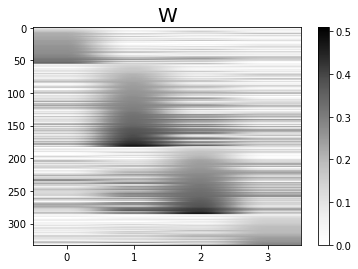

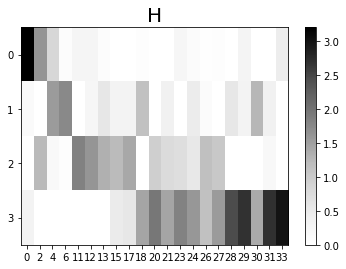

In [293]:
plt.imshow(W_sorted,aspect='auto',interpolation=None,cmap='Greys')
plt.xticks(range(W_sorted.shape[1]))
plt.colorbar()
plt.title('W')

fig,ax=plt.subplots()
im=ax.imshow(H_sorted,aspect='auto',cmap='Greys')
# ax.set_xticks(range(H_sorted.shape[1]))

xticklabels=np.nonzero(behavior['trials']['visitedArm']==ch)[0]
ax.set_xticks(np.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels)

ax.set_yticks(range(H_sorted.shape[0]))
ax.set_title('H')
plt.colorbar(im)


In [136]:
W_sorted

array([[0.05344153, 0.04645442, 0.        ],
       [0.08136438, 0.05552296, 0.        ],
       [0.08142297, 0.07638223, 0.        ],
       [0.08407239, 0.02975585, 0.03718111],
       [0.09214353, 0.04365322, 0.05132714],
       [0.12788193, 0.1078775 , 0.09139434],
       [0.14797588, 0.10473887, 0.11638227],
       [0.14928613, 0.0973456 , 0.05852283],
       [0.15492929, 0.11384087, 0.11835181],
       [0.15943701, 0.04456075, 0.07440636],
       [0.16663522, 0.        , 0.06367841],
       [0.16844005, 0.14704511, 0.14894706],
       [0.1776306 , 0.06062591, 0.04738056],
       [0.18203748, 0.        , 0.        ],
       [0.18203748, 0.        , 0.        ],
       [0.18711509, 0.        , 0.        ],
       [0.18958839, 0.        , 0.01300809],
       [0.1941968 , 0.0692577 , 0.06967005],
       [0.19423867, 0.        , 0.        ],
       [0.19513324, 0.12270624, 0.18543519],
       [0.19711433, 0.        , 0.        ],
       [0.20196929, 0.17570707, 0.1534228 ],
       [0.

In [207]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

[Text(0, 0, '0'),
 Text(1, 0, '2'),
 Text(2, 0, '4'),
 Text(3, 0, '6'),
 Text(4, 0, '11'),
 Text(5, 0, '12'),
 Text(6, 0, '13'),
 Text(7, 0, '15'),
 Text(8, 0, '17'),
 Text(9, 0, '18'),
 Text(10, 0, '20'),
 Text(11, 0, '21'),
 Text(12, 0, '23'),
 Text(13, 0, '24'),
 Text(14, 0, '26'),
 Text(15, 0, '27'),
 Text(16, 0, '28'),
 Text(17, 0, '29'),
 Text(18, 0, '30'),
 Text(19, 0, '31'),
 Text(20, 0, '33')]

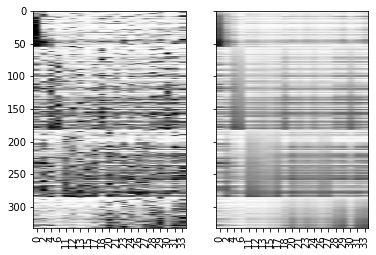

In [294]:
fig,axs=plt.subplots(1,2,sharex=True,sharey=True)
axs[0].imshow(X_sorted,aspect='auto',interpolation=None)
axs[1].imshow(X_recon_sorted,aspect='auto',interpolation=None)
xticklabels=np.nonzero(behavior['trials']['visitedArm']==ch)[0]
axs[0].set_xticks(np.arange(len(xticklabels)))
axs[0].set_xticklabels(xticklabels,rotation=90)
axs[1].set_xticklabels(xticklabels,rotation=90)

<AxesSubplot:>

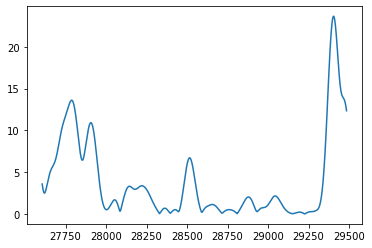

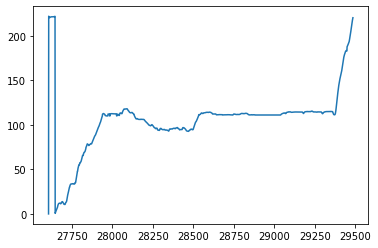

In [268]:
tt=18
fr.query('trial==@tt')['speed'].plot()
plt.figure()
fr.query('trial==@tt')['lin'].plot()

[Text(0, 0, '0'),
 Text(1, 0, '2'),
 Text(2, 0, '4'),
 Text(3, 0, '6'),
 Text(4, 0, '11'),
 Text(5, 0, '12'),
 Text(6, 0, '13'),
 Text(7, 0, '15'),
 Text(8, 0, '17'),
 Text(9, 0, '18'),
 Text(10, 0, '20'),
 Text(11, 0, '21'),
 Text(12, 0, '23'),
 Text(13, 0, '24'),
 Text(14, 0, '26'),
 Text(15, 0, '27'),
 Text(16, 0, '28'),
 Text(17, 0, '29'),
 Text(18, 0, '30'),
 Text(19, 0, '31'),
 Text(20, 0, '33')]

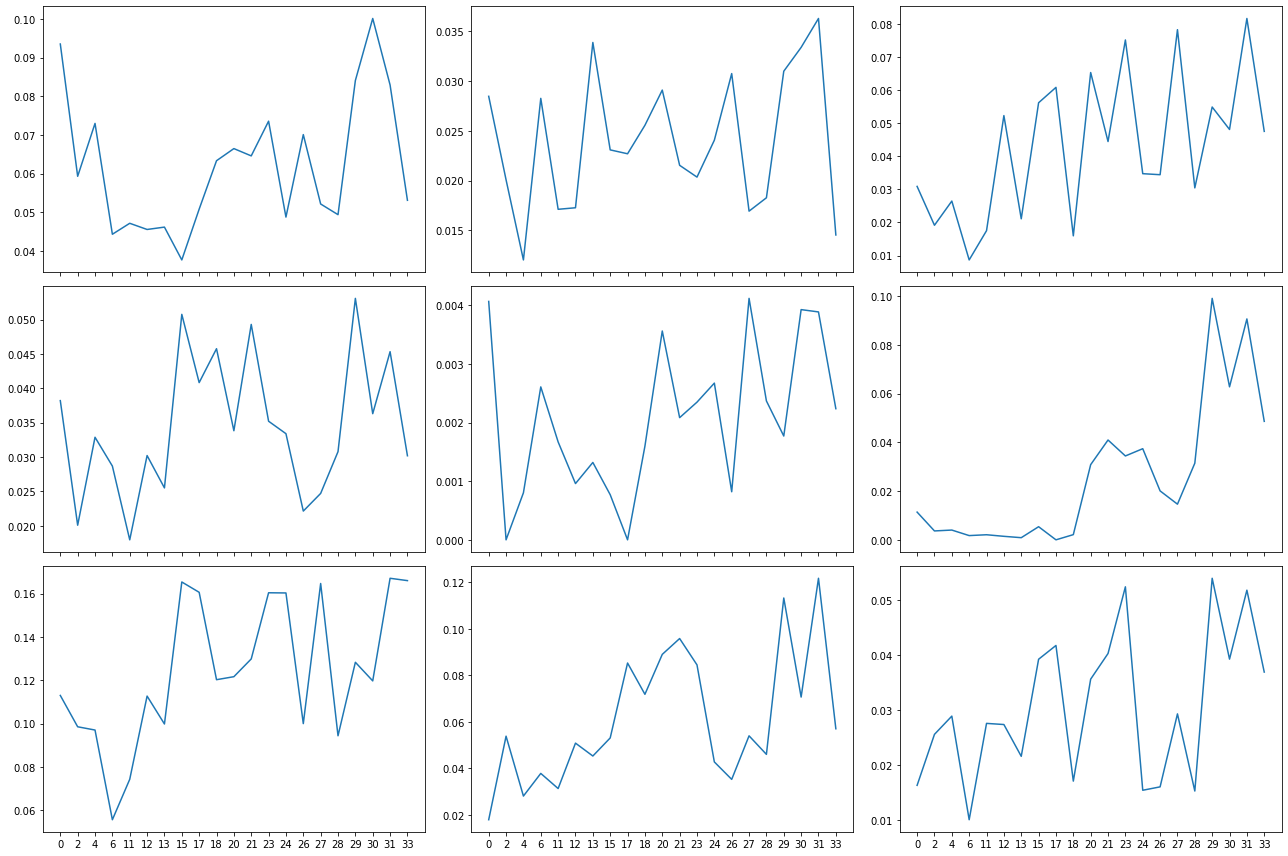

In [262]:
fr_mean_trial_sorted = fr_mean_trial[pyr_mask][W_inds]

cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)

ii_to_plot = range(-10,-1)
clust_to_plot=3
ntoplot=len(ii_to_plot)
fig,axs=ph.subplots_wrapper(ntoplot,return_axs=True,sharex=True)
for pp,ii in enumerate(ii_to_plot):
#     unit_name=cell_cols_pyr[pyr_mask][W_inds][ii]

#     unit_original_ind=np.nonzero(cell_cols_pyr == unit_name)[0][0]

#     axs.ravel()[pp].plot(fr_mean_trial[unit_original_ind])
    ma = factor_assignment==clust_to_plot
    ax=axs.ravel()[pp]
    ax.plot(fr_mean_trial_sorted[ma][ii])
    ax.set_xticks(range(fr_mean_trial_sorted[ma][ii].shape[0]))
plt.tight_layout()

xticklabels=np.nonzero(behavior['trials']['visitedArm']==ch)[0]
ax.set_xticks(np.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels)

In [181]:
def sort_factors(W):
    factor_assignment=np.argmax(W,axis=1)
    nfactors= W.shape[1]
    inds_within_all_l=[]
    for f in range(nfactors):
        mask = factor_assignment==f
        inds = np.nonzero(mask)[0]
        inds_within_all=inds[np.argsort(W[mask][:,f])]
        inds_within_all_l.append(inds_within_all)
    inds_within_all_l = np.concatenate(inds_within_all_l)
    return inds_within_all_l, W[inds_within_all_l],factor_assignment[inds_within_all_l]

def sort_by_peak_within_factor(H):
    '''
    H: nfactors x ntrials
    '''
    inds = np.argsort(H.argmax(axis=1))
    return inds, H[inds]
    